# Monet Cycle-GAN Project
--------------------------------------------------------------------------------

Author: Kevin Paganini    
Date: 11/29/2022     
Description: 
We recognize the works of artists through their unique style, such as color choices or brush strokes. The “je ne sais quoi” of artists like Claude Monet can now be imitated with algorithms thanks to generative adversarial networks (GANs). In this getting started competition, you will bring that style to your photos or recreate the style from scratch!

Computer vision has advanced tremendously in recent years and GANs are now capable of mimicking objects in a very convincing way. But creating museum-worthy masterpieces is thought of to be, well, more art than science. So can (data) science, in the form of GANs, trick classifiers into believing you’ve created a true Monet? That’s the challenge you’ll take on!

The Challenge:
A GAN consists of at least two neural networks: a generator model and a discriminator model. The generator is a neural network that creates the images. For our competition, you should generate images in the style of Monet. This generator is trained using a discriminator.

The two models will work against each other, with the generator trying to trick the discriminator, and the discriminator trying to accurately classify the real vs. generated images.

Your task is to build a GAN that generates 7,000 to 10,000 Monet-style images.

### Imports and setup

In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as img
import tensorflow as tf
from tensorflow import keras
from keras import layers
import glob as gb
import cv2
import os



pd.set_option('display.max_rows', 250)


# makes plots nice
def make_pretty(ax, title='', x_label='', y_label='', img=False):
    ax.set_title(title, fontsize=20)
    ax.set_xlabel(x_label, fontsize=16)
    ax.set_ylabel(y_label, fontsize=16)
    ax.legend(loc='best', fontsize=16)
    if img:
        ax.axis('off')
    return ax


monet_jpg_path = os.path.join('data', 'monet_jpg')
photo_jpg_path = os.path.join('data', 'photo_jpg')

In [19]:
total_monet_jpg = 0
for d in os.listdir(monet_jpg_path):
    total_monet_jpg += 1

print(f'Total monet jpg images: {total_monet_jpg}')



total_photo_jpg = 0
for d in os.listdir(photo_jpg_path):
    total_photo_jpg += 1

print(f'Total photo jpg images: {total_photo_jpg}')




Total monet jpg images: 300
Total photo jpg images: 7038


### Displaying some monet pictures

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


<AxesSubplot: >

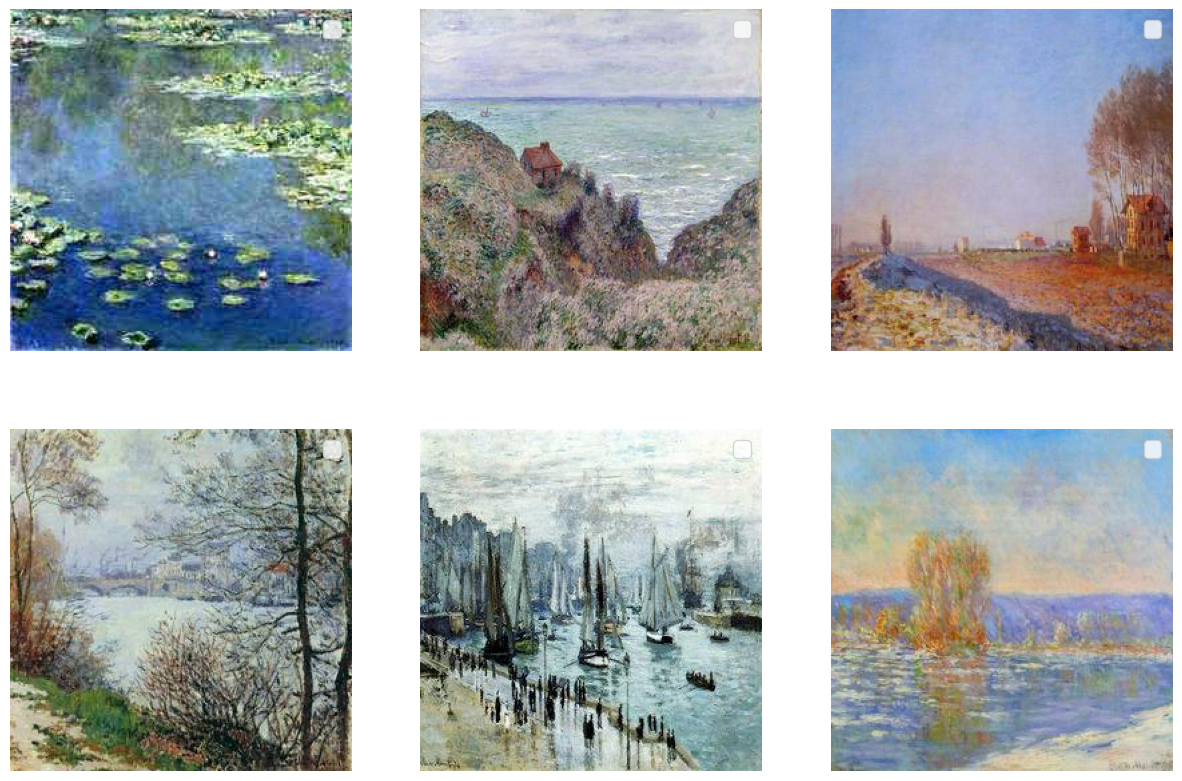

In [17]:
monet_img1 = img.imread(os.path.join(monet_jpg_path, 'ec78d80dbd.jpg'))
monet_img2 = img.imread(os.path.join(monet_jpg_path, 'e2253b87a0.jpg'))
monet_img3 = img.imread(os.path.join(monet_jpg_path, 'f821791c85.jpg'))
monet_img4 = img.imread(os.path.join(monet_jpg_path, 'f0d789c4bc.jpg'))
monet_img5 = img.imread(os.path.join(monet_jpg_path, 'fc11d52502.jpg'))
monet_img6 = img.imread(os.path.join(monet_jpg_path, 'e510a74d3c.jpg'))


fig, ax = plt.subplots(figsize=(15, 10), nrows=2, ncols=3)

ax[0,0].imshow(monet_img1)
make_pretty(ax[0,0], img=True)
ax[0,1].imshow(monet_img2)
make_pretty(ax[0,1], img=True)
ax[0,2].imshow(monet_img3)
make_pretty(ax[0,2], img=True)
ax[1,0].imshow(monet_img4)
make_pretty(ax[1,0], img=True)
ax[1,1].imshow(monet_img5)
make_pretty(ax[1,1], img=True)
ax[1,2].imshow(monet_img6)
make_pretty(ax[1,2], img=True)



### Reading and making sure we have regular shape images

In [21]:
def find_shape(path):
    size = []
    
    
    
        
    images = gb.glob(pathname=str(path + '/' + '/*jpg'))
    
    for file in images:
        img = plt.imread(file)
        size.append(img.shape)
    
    return pd.Series(size).value_counts()

find_shape(monet_jpg_path)

300


(256, 256, 3)    300
dtype: int64

All monet images are the same shape. Nice.

In [22]:
find_shape(photo_jpg_path)

7038


(256, 256, 3)    7038
dtype: int64

All images that we are generating on are the same size. :)

### Train data

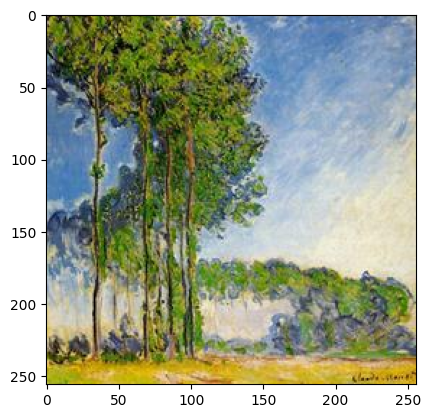

In [30]:
def get_data():
    
    X_train = []
    
    images = gb.glob(pathname=str(monet_jpg_path + '/' + '/*jpg'))
    
    for file in images:
        img = cv2.imread(file)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        X_train.append(img)
    
    return np.array(X_train)


X_train = get_data()
X_train.shape
fig, ax = plt.subplots()

ax.imshow(X_train[5])



### Explanation of Cycle GANs

The problem we are trying to tackle is an unpaired Image-to_image translation. Since it is impossible to have a dataset that includes pairs of images plus their monet counterparts we have come up with a clever way solve the problem. 

In this project we are doing an Image-to-Image translation task. At a high level we are training to 4 models. Two of them will be generators and two of them will be discriminators. In our case we will be making a generator that will take an input image X (a real image in our case) and produce an output image Y (a monet style painting of the input image). The discrimninator will try to discern whether the an image provided to it is a real monet or a fake produce by the generator. The second generator we will produce is a generator that as input will take an input image Y and produce the output image X. The discrimnator in this case will try to determine whether the an image provided to it is a real image or a fake produce by the generator.   


- A discriminative model learns a function that maps the input data (x) to some desired output class label (y). In probabilistic terms, they directly learn the conditional distribution P(y|x).

- A generative model tries to learn the joint probability of the input data and labels simultaneously, i.e. P(x,y). This can be converted to P(y|x) for classification via Bayes rule, but the generative ability could be used for something else as well, such as creating likely new (x, y) samples.

This setup may also seem somewhat reminiscent of reinforcement learning, where the generator is receiving a reward signal from the  discriminator letting it know whether the generated data is accurate or not. The key difference with GANs however is that we can backpropagate gradient information from the discriminator back to the generator network, so the generator knows how to adapt its parameters in order to produce output data that can fool the discriminator.

This architecture alone could be enough to produce plausible images in the other domain, however it won't produce translations of the input images. This is why we need to use cycle consistency. The idea here is that the output of one generator model can be used as an input to the other generator model. The output of the second generator model should produce the original input image. We ensure this by introducing another factor to our loss function. We measure the difference between the final output image and the original input to enforce this.

# Sources and Links
---------------------------------------------------------------

### Code Implementation
https://hardikbansal.github.io/CycleGANBlog/

### Papers
[Unpaired img2img translation Cycle-Consistent Adversarial Networks](https://arxiv.org/abs/1703.10593)     
[Perceptual Losses for Real-Time Style Transfer and Super-Resolution](https://arxiv.org/abs/1603.08155)    
[Image-to-Image Translation with Conditional Adversarial Networks](https://arxiv.org/abs/1611.07004)     
[Least squares generative adversarial networks](https://arxiv.org/abs/1611.04076)    
[Learning from Simulated and Unsupervised Images through Adversarial Training,](https://arxiv.org/abs/1612.07828)    
[useful KAGGLE GAN](https://www.kaggle.com/code/quadeer15sh/introduction-to-dc-gans)